In [1]:
cd /tf/astromer

/tf/astromer


In [2]:
import tensorflow as tf
import json
import os

from core.data  import pretraining_records
from core.astromer import get_ASTROMER, train

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
exp_path = './runs/lr_1e-5'

In [4]:
conf_file = os.path.join(exp_path, 'conf.json')

with open(conf_file, 'r') as handle:
    conf = json.load(handle)
conf

{'max_obs': 50,
 'data': './data/records/macho',
 'p': './runs/lr_1e-5',
 'batch_size': 5000,
 'epochs': 10000,
 'patience': 2000,
 'repeat': 1,
 'layers': 2,
 'heads': 4,
 'head_dim': 128,
 'dff': 128,
 'dropout': 0.1,
 'base': 1000,
 'lr': 1e-05,
 'exp_date': '2021-06-17 23:13:13'}

In [5]:
test_batches = pretraining_records(os.path.join('./data/records/macho2', 'test'), 
                            conf['batch_size'], 
                            max_obs=conf['max_obs'])

sum([1 for x in test_batches.unbatch()])

93924

In [6]:
astromer = get_ASTROMER(num_layers=conf['layers'],
                        d_model=conf['head_dim'],
                        num_heads=conf['heads'],
                        dff=conf['dff'],
                        base=conf['base'],
                        dropout=conf['dropout'],
                        maxlen=conf['max_obs'])

In [7]:
# tf.keras.utils.plot_model(astromer, show_shapes=True)

In [8]:
weights_path = '{}/weights'.format(conf['p'])
astromer.load_weights(weights_path)

In [9]:
from core.astromer import predict

In [10]:
result = predict(astromer, test_batches, conf)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['lcid', 'label', 'original'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 19it [00:52,  2.77s/it]


In [13]:
from sklearn.metrics import r2_score

In [20]:
y_pred = result['y_pred']
y_true = result['y_true']


r2 = r2_score(y_true, y_pred)
r2

0.9995741184384077

In [11]:
print('acc: {}\nmse: {}'.format(result['acc'], result['mse']))

acc: 0.9998947978019714
mse: 0.035811446607112885


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


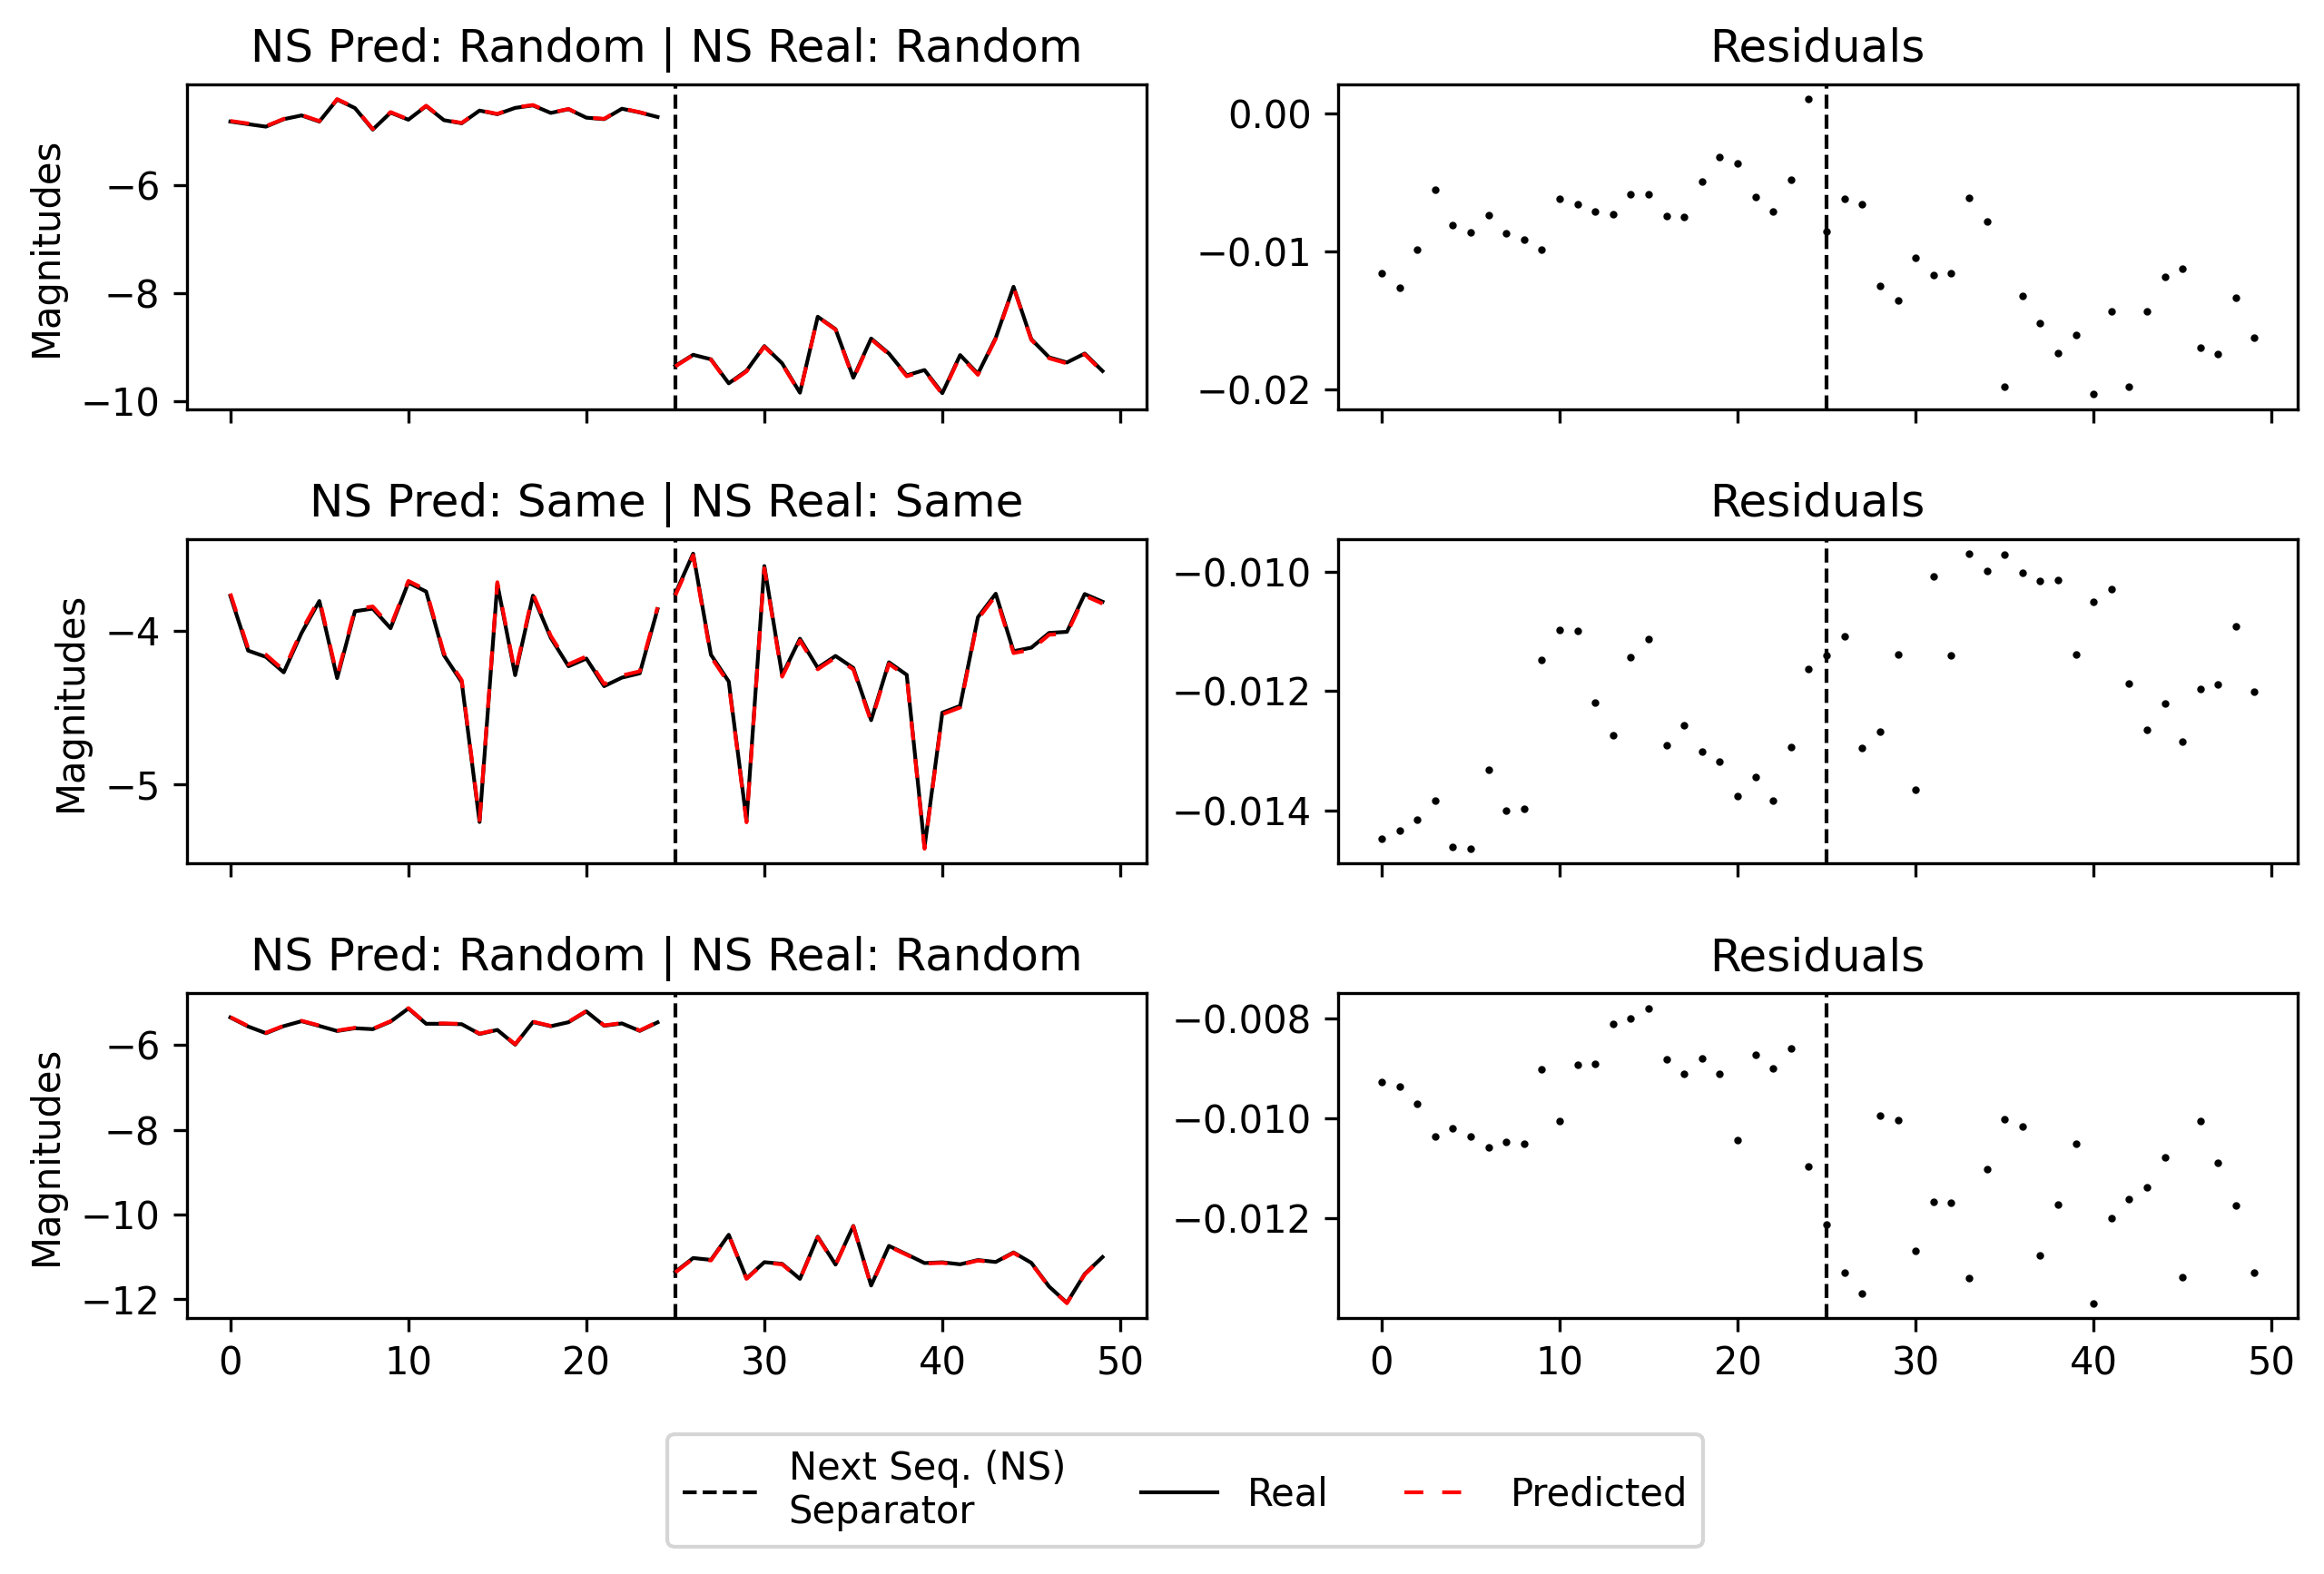

In [12]:
N = 3
fig, axes = plt.subplots(N, 2, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, conf['max_obs'])

    serie_1_pred = result['x_pred'][i][:obs, 0]
    serie_1_true = result['x_true'][i][:obs, 0]
    residual_1 = serie_1_pred - serie_1_true

    serie_2_pred = result['x_pred'][i][obs+1:-1, 0]
    serie_2_true = result['x_true'][i][obs:, 0]

    
    residual_2 = serie_2_pred - serie_2_true
    
    axes[i][0].axvline(x=obs, color='k', linewidth=1, linestyle='--', label='Next Seq. (NS)\nSeparator')

    axes[i][0].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='k')
    axes[i][0].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))
    
    axes[i][0].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    axes[i][1].plot(times_prev, residual_1, '.', markersize=2, color='k')
    axes[i][1].plot(times_post, residual_2, '.', markersize=2, color='k')
    axes[i][1].axvline(x=obs, color='k', linewidth=1, linestyle='--')
    axes[i][1].set_title('Residuals')
    
    
    npp_lab_pred = 'Random' if result['y_pred'][i] == 1 else 'Same'
    npp_lab_true = 'Random' if result['y_true'][i] == 1 else 'Same'
    axes[i][0].set_title(r"NS Pred: "+npp_lab_pred+" | "+r"NS Real: "+npp_lab_true)

    axes[i][0].set_ylabel('Magnitudes')
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (1.6, -0.3))
fig.tight_layout()

## Learning Curves

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
from tensorboard.backend.event_processing import event_accumulator

def my_summary_iterator(path):
    for r in tf_record.tf_record_iterator(path):
        yield event_pb2.Event.FromString(r)

def get_metrics(path_logs):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][0]
    path_train = os.path.join(path_logs, train_logs)

    ea = event_accumulator.EventAccumulator(path_train)
    ea.Reload()

    metrics = {tag:[] for tag in ea.Tags()['tensors']}
    for e in my_summary_iterator(path_train):
        for v in e.summary.value:
            if v.tag == 'model': continue
            value = tf.make_ndarray(v.tensor)
            metrics[v.tag].append(value)
    return metrics

In [14]:
pathexp = conf['p']
train_metrics = get_metrics(os.path.join(pathexp, 'logs', 'train'))
val_metrics = get_metrics(os.path.join(pathexp, 'logs', 'valid'))

Text(0.52, 0.05, 'Number of Epochs')

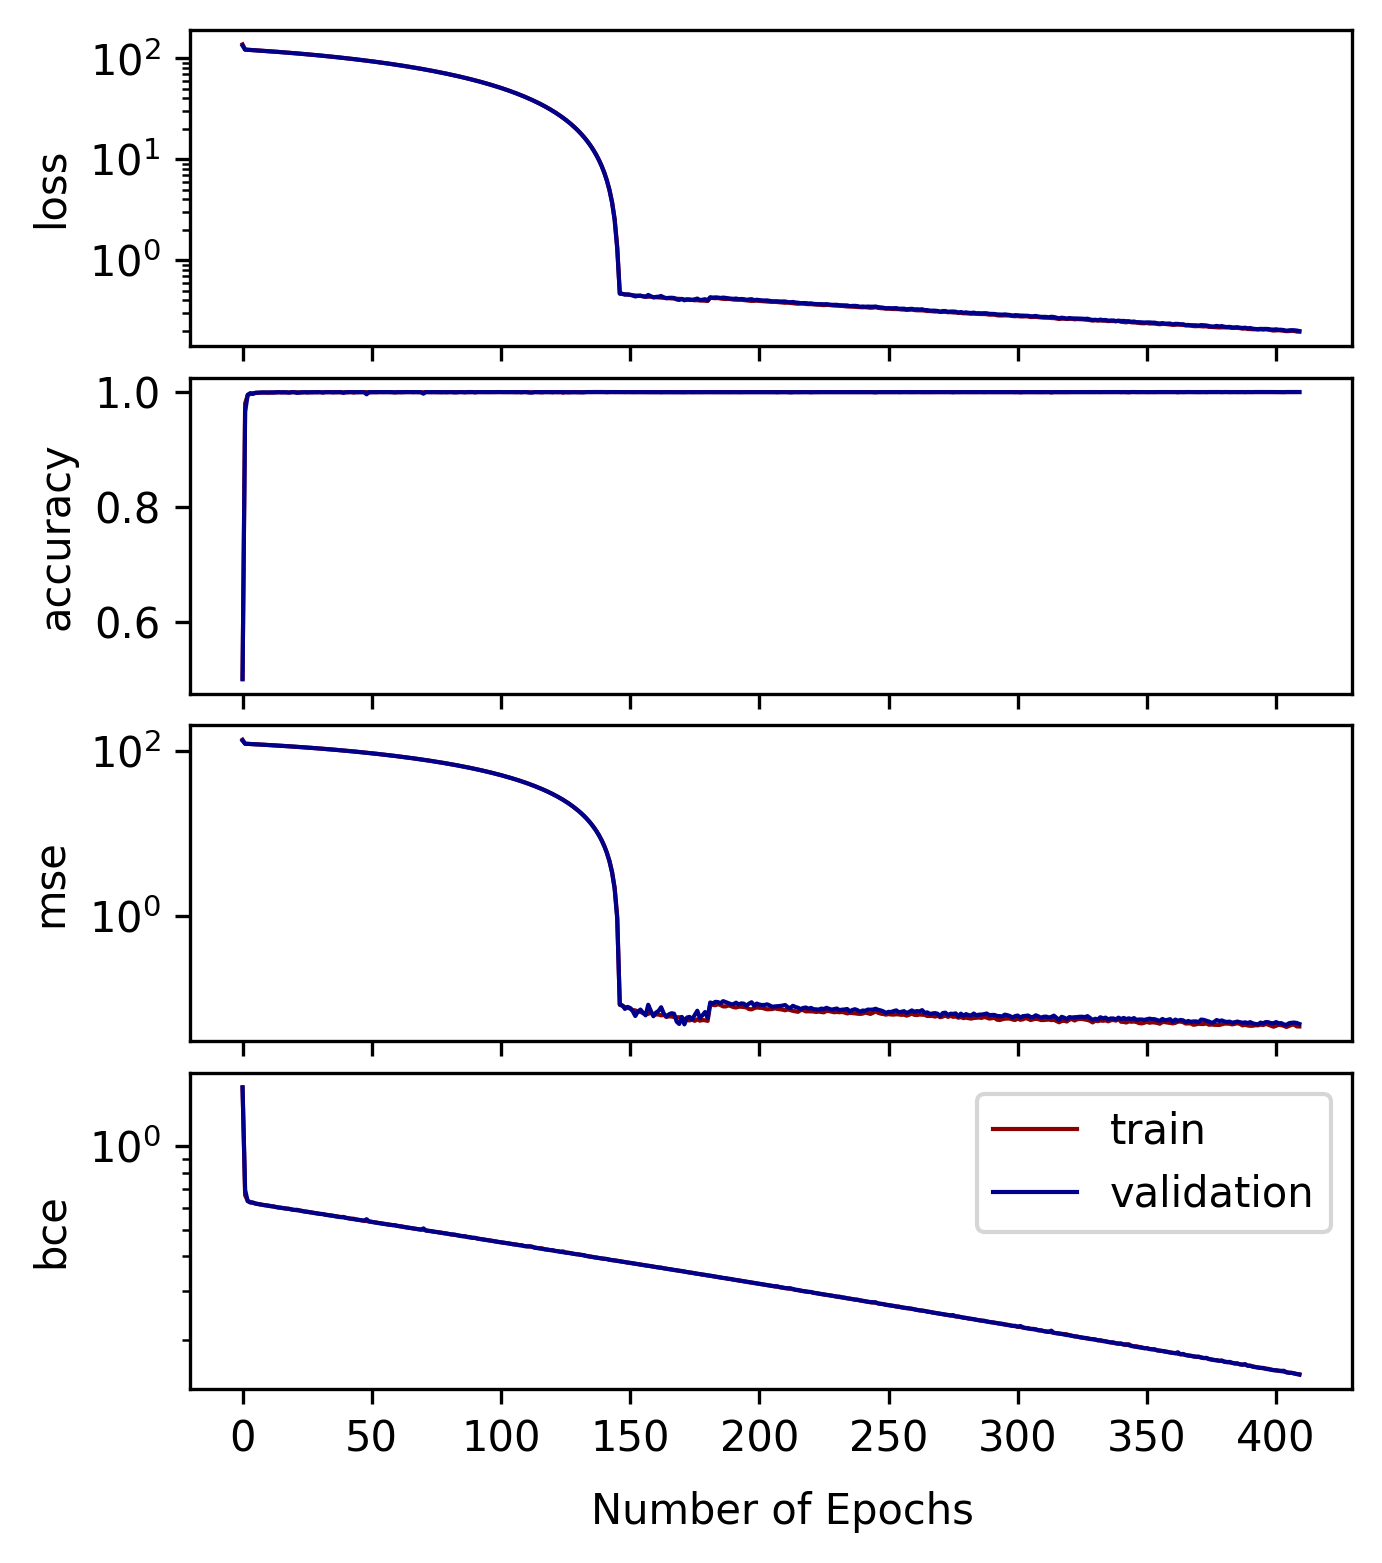

In [15]:
fig, axes = plt.subplots(4, 1, figsize=(5,6), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes[i].plot(train_values, label='train', color='darkred', linewidth=1)
    axes[i].plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    axes[i].set_ylabel(key)
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[-1].legend(loc='upper right')
fig.text(0.52, 0.05, 'Number of Epochs', ha='center')

## Finetuning

In [33]:
conf_file = os.path.join(conf['p'], 'finetuning', 'model_1','conf.json')
with open(conf_file, 'r') as handle:
    conf_ft = json.load(handle)
conf_ft

{'max_obs': 50,
 'data': './data/records/macho3/',
 'p': './runs/macho_old_pe/finetuning/model_1',
 'batch_size': 256,
 'epochs': 3000,
 'patience': 2000,
 'finetuning': False,
 'repeat': 1,
 'layers': 1,
 'heads': 2,
 'head_dim': 106,
 'dff': 512,
 'dropout': 0.1,
 'base': 1000,
 'lr': 0.001}

In [34]:
test_batches_ft = pretraining_records(os.path.join('./data/records/macho3', 'test'), 
                            conf_ft['batch_size'], 
                            max_obs=conf_ft['max_obs'])

sum([1 for x in test_batches_ft.unbatch()])

10404

In [35]:
ft_model = get_ASTROMER(num_layers=conf_ft['layers'],
                        d_model=conf_ft['head_dim'],
                        num_heads=conf_ft['heads'],
                        dff=conf_ft['dff'],
                        base=conf_ft['base'],
                        dropout=conf_ft['dropout'],
                        maxlen=conf_ft['max_obs'])

In [36]:
weights_path = '{}/weights'.format(conf_ft['p'])
ft_model.load_weights(weights_path)

In [37]:
result = predict(ft_model, test_batches_ft, conf_ft)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:591: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 41it [00:03, 12.13it/s]


In [38]:
print(result['acc'], result['mse'])

0.971585 8.285091e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


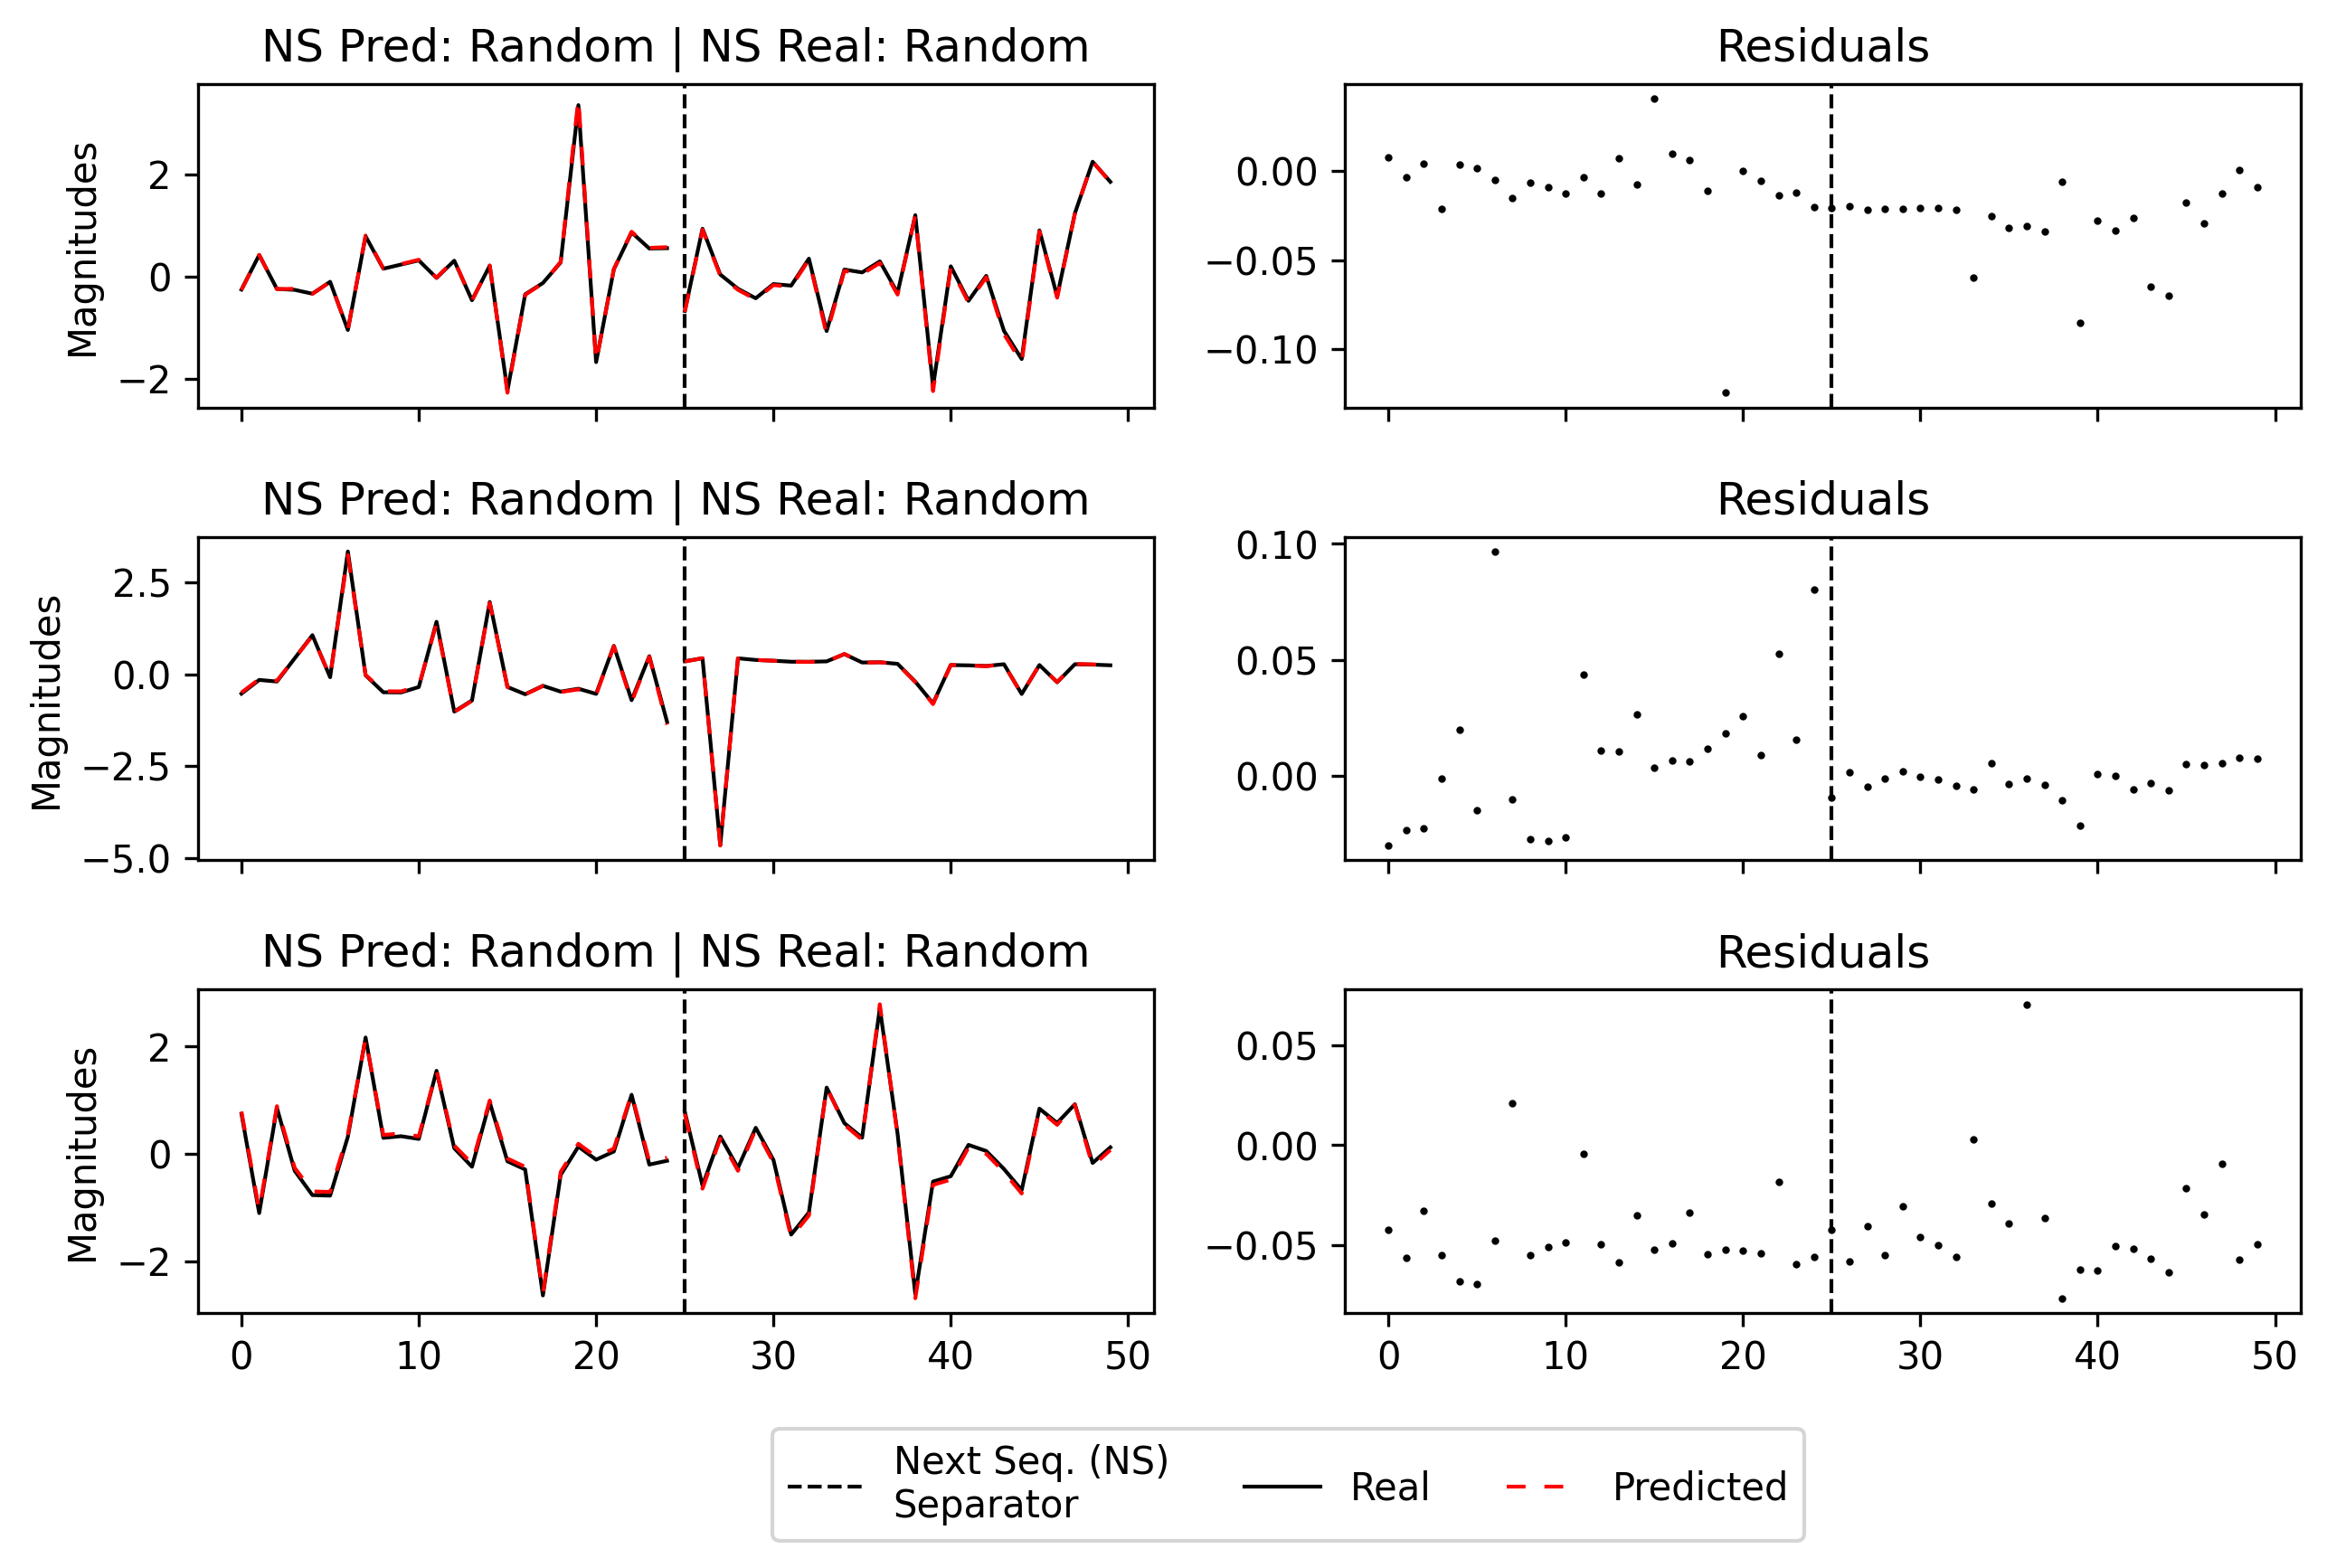

In [39]:
N = 3
fig, axes = plt.subplots(N, 2, dpi=300, figsize=(10,6),
                         gridspec_kw={'hspace': 0.4, 'wspace': 0.2},
                         sharey=False, sharex=True)

obs = conf['max_obs']//2

for i in range(N):

    times_prev = range(0, obs)
    times_post = range(obs, conf['max_obs'])
    

    serie_1_pred = result['x_true'][i][1:obs+1]
    serie_1_true = result['x_pred'][i][:obs]

    residual_1 = serie_1_pred - serie_1_true

    serie_2_pred = result['x_true'][i][obs+2:-1]
    serie_2_true = result['x_pred'][i][obs+1:-1]

    residual_2 = serie_2_pred - serie_2_true
    
    axes[i][0].axvline(x=obs, color='k', linewidth=1, linestyle='--', label='Next Seq. (NS)\nSeparator')

    axes[i][0].plot(times_prev, serie_1_pred, marker='',linewidth=1, linestyle='-', color='k')
    axes[i][0].plot(times_prev, serie_1_true, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5))
    
    axes[i][0].plot(times_post, serie_2_true, marker='',linewidth=1, linestyle='-', color='k', label='Real')
    axes[i][0].plot(times_post, serie_2_pred, marker='',linewidth=1, linestyle='--', color='red', dashes=(5, 5),label='Predicted')
    

    axes[i][1].plot(times_prev, residual_1, '.', markersize=2, color='k')
    axes[i][1].plot(times_post, residual_2, '.', markersize=2, color='k')
    axes[i][1].axvline(x=obs, color='k', linewidth=1, linestyle='--')
    axes[i][1].set_title('Residuals')
    
    
    npp_lab_pred = 'Random' if result['y_pred'][i] == 1 else 'Same'
    npp_lab_true = 'Random' if result['y_true'][i] == 1 else 'Same'
    axes[i][0].set_title(r"NS Pred: "+npp_lab_pred+" | "+r"NS Real: "+npp_lab_true)

    axes[i][0].set_ylabel('Magnitudes')
    
axes[-1][0].legend(ncol=3, bbox_to_anchor = (1.7, -0.3))
fig.tight_layout()

In [40]:
train_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'train'))
val_metrics = get_metrics(os.path.join(conf_ft['p'], 'logs', 'valid'))

Text(0.52, 0.05, 'Number of Epochs')

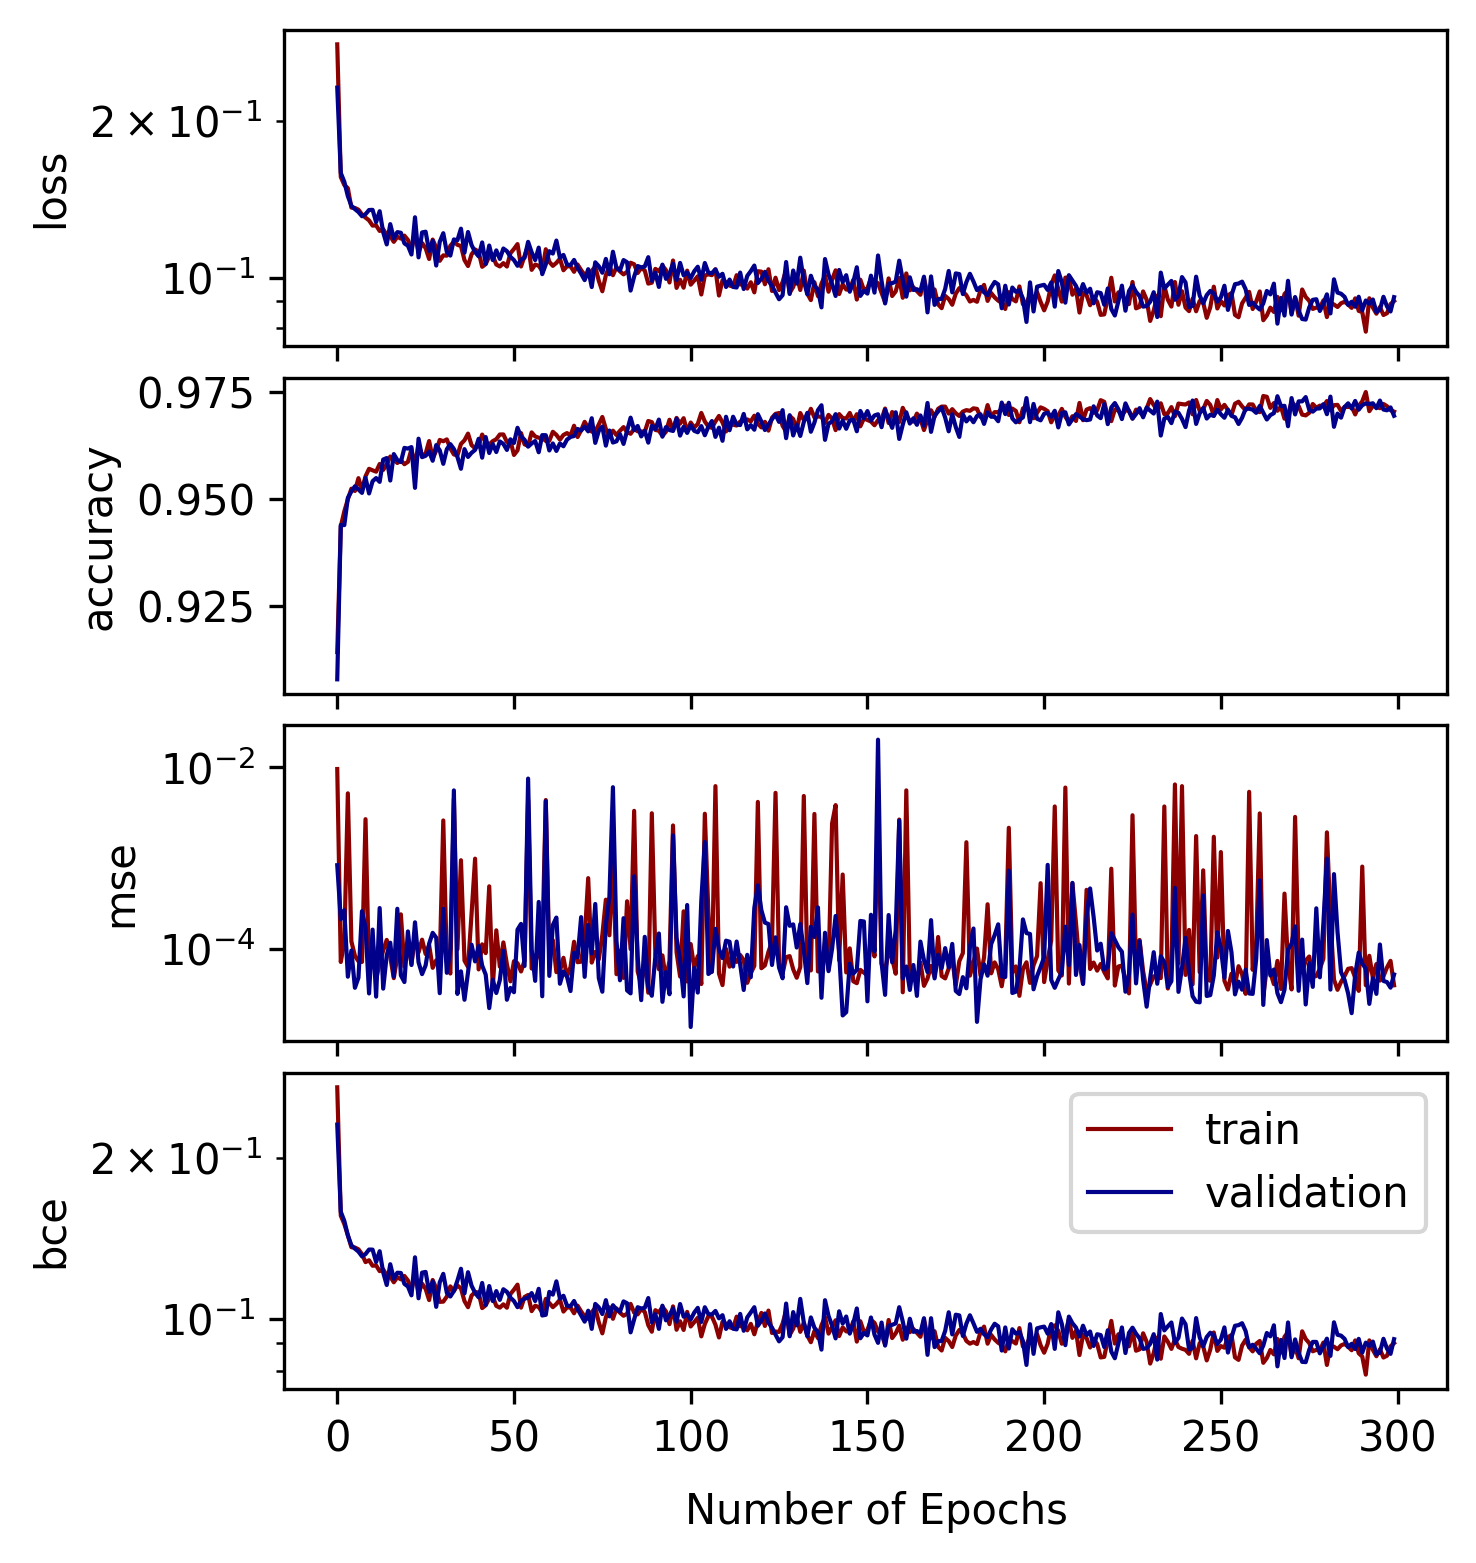

In [41]:
fig, axes = plt.subplots(4, 1, figsize=(5,6), sharex=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes[i].plot(train_values, label='train', color='darkred', linewidth=1)
    axes[i].plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    axes[i].set_ylabel(key)
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[-1].legend(loc='upper right')
fig.text(0.52, 0.05, 'Number of Epochs', ha='center')

## Special Task: Classification

In [200]:
from core.astromer_clf import get_CLASSIFIER, predict
from core.data import classification_records

In [235]:
conf_file = os.path.join(conf['p'], 'finetuning', 'model_1','classification','rnn_0','conf.json')

with open(conf_file, 'r') as handle:
    conf_rnn = json.load(handle)
conf_rnn

{'max_obs': 50,
 'data': './data/records/macho3/',
 'p': './runs/macho_old_pe/finetuning/model_1/classification/rnn_0',
 'batch_size': 256,
 'epochs': 2000,
 'patience': 1000,
 'finetuning': False,
 'repeat': 1,
 'layers': 1,
 'heads': 2,
 'head_dim': 106,
 'dff': 512,
 'dropout': 0.2,
 'base': 1000,
 'lr': 0.001,
 'take': 1,
 'astromer': './runs/macho_old_pe/finetuning/model_1/',
 'units': 64}

In [ ]:
pd.read_csv(os.path.join(conf_rnn['data']))

In [236]:
test_batches_rnn = classification_records(os.path.join('./data/records/macho3', 'test'), 
                                          conf_rnn['batch_size'], 
                                          max_obs=conf_rnn['max_obs'])

sum([1 for x in test_batches_rnn.unbatch()])

10404

In [237]:
clf_model = get_CLASSIFIER(ft_model, conf_rnn['units'], conf_rnn['dropout'], 2)

In [238]:
weights_path = '{}/weights'.format(conf_rnn['p'])
clf_model.load_weights(weights_path)

In [239]:
result = predict(clf_model, test_batches_rnn, conf_rnn)

prediction: 0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['tar_mask', 'length', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])
prediction: 41it [00:04,  9.18it/s]


In [240]:
print(result['acc'], result['bce'])

0.9367518 0.19193467


In [241]:
train_metrics = get_metrics(os.path.join(conf_rnn['p'], 'logs', 'train'))
val_metrics = get_metrics(os.path.join(conf_rnn['p'], 'logs', 'valid'))

{'images': [], 'audio': [], 'histograms': [], 'scalars': [], 'distributions': [], 'tensors': ['model', 'accuracy', 'xentropy'], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': [], 'distributions': [], 'tensors': ['accuracy', 'xentropy'], 'graph': False, 'meta_graph': False, 'run_metadata': []}


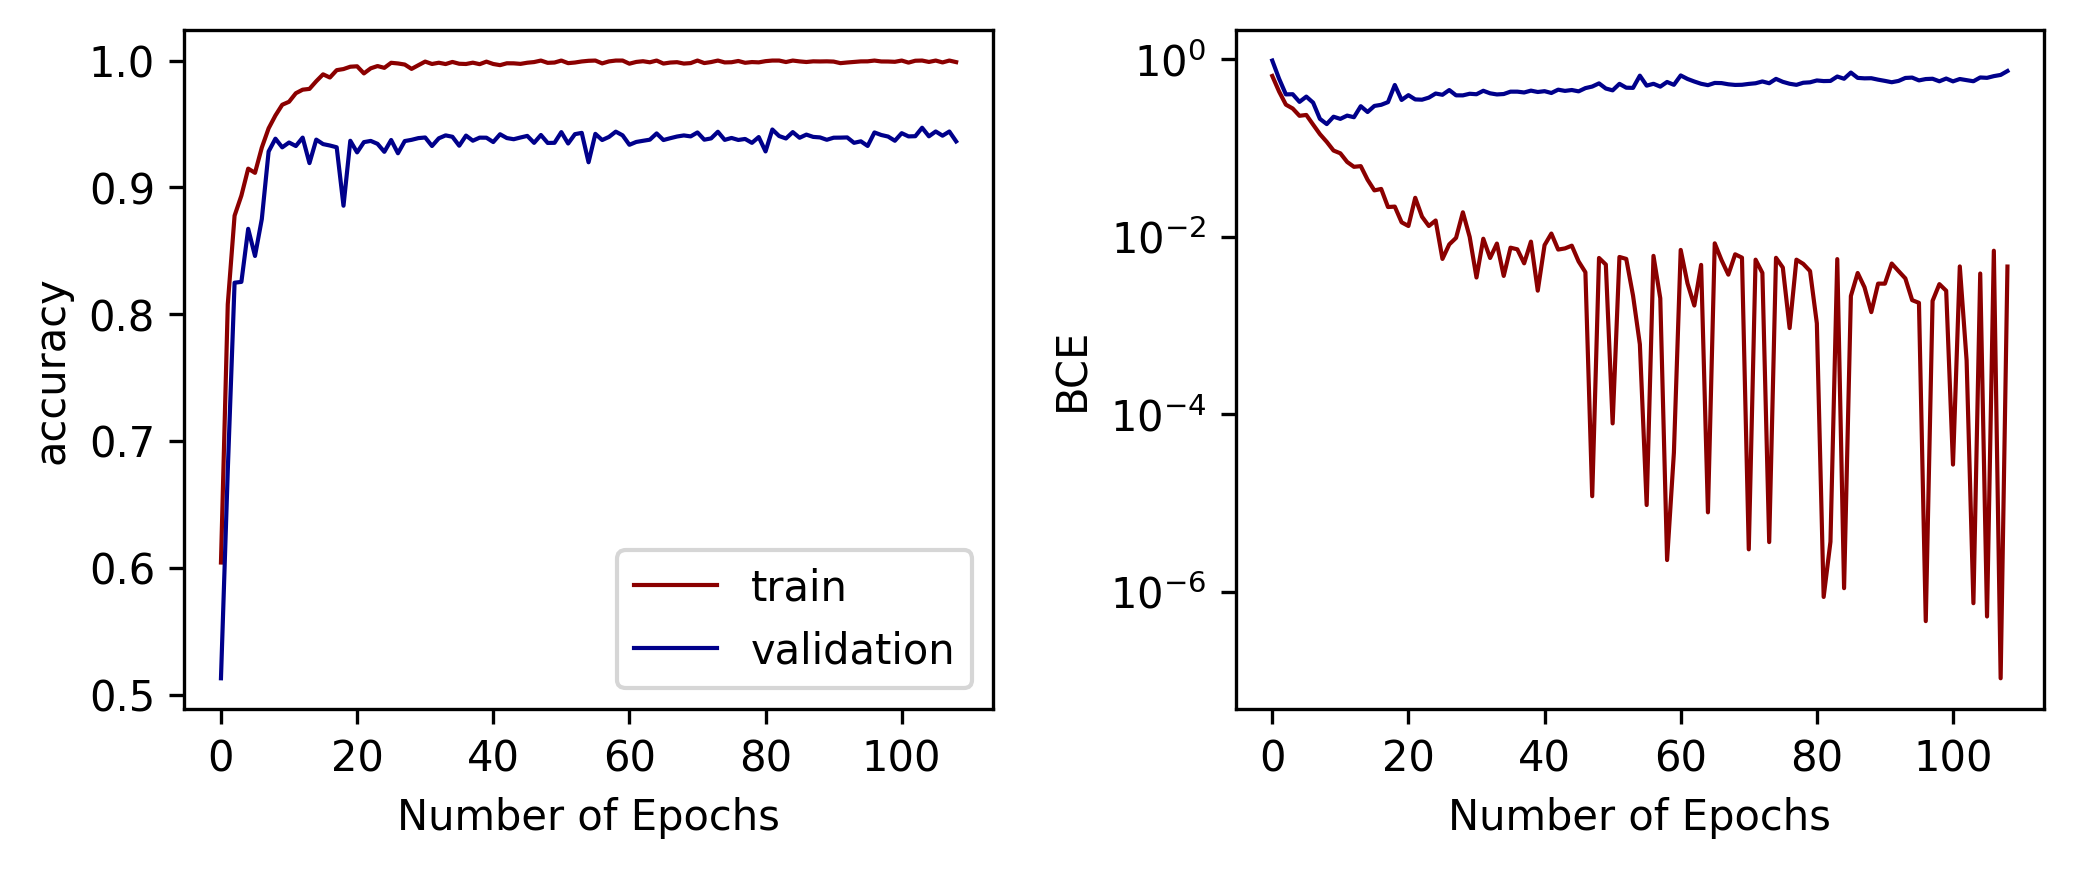

In [242]:
fig, axes = plt.subplots(1, 2, figsize=(8,3),gridspec_kw={'hspace': 0.1, 'wspace': 0.3}, dpi=300)
for i, key in enumerate(val_metrics.keys()):
    
    train_values = np.array(train_metrics[key])
    train_values = train_values[np.arange(0, len(train_values), 10)]
    vaild_values = np.array(val_metrics[key])
    vaild_values = vaild_values[np.arange(0, len(vaild_values), 10)]
    
    axes[i].plot(train_values, label='train', color='darkred', linewidth=1)
    axes[i].plot(vaild_values, label='validation', color='darkblue', linewidth=1)
    if key == 'xentropy':
        axes[i].set_ylabel('BCE')
    else:
        axes[i].set_ylabel(key)
        
    axes[i].set_xlabel('Number of Epochs')
    if key != 'accuracy':
        axes[i].set_yscale('log')
axes[0].legend(loc='lower right')


In [247]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_cm(cm, ax, title='CM', fontsize=15, cbar=False, yticklabels=True):
    labels = np.zeros_like(cm, dtype=np.object)
    mask = np.ones_like(cm, dtype=np.bool)
    for (row, col), value in np.ndenumerate(cm):
        if value != 0.0:
            mask[row][col] = False
        if value < 0.01:
            labels[row][col] = '< 1%'
        else:
            labels[row][col] = '{:2.1f}%'.format(value*100)

    ax = sns.heatmap(cm, annot = labels, fmt = '', 
                     annot_kws={"size": fontsize}, 
                     cbar=cbar,
                     ax=ax,
                     linecolor='white',
                     linewidths=1,
                     vmin=0, vmax=1,
                     cmap='Blues',
                     mask=mask,
                     yticklabels=yticklabels)
    ax.set_xticklabels(class_names, rotation=90, fontsize=fontsize+1)
    if yticklabels:
        ax.set_yticklabels(class_names, rotation=0, fontsize=fontsize+1)
    ax.set_title(title, fontsize=fontsize+5)
    
    ax.axhline(y=0, color='k',linewidth=4)
    ax.axhline(y=cm.shape[1], color='k',linewidth=4)
    ax.axvline(x=0, color='k',linewidth=4)
    ax.axvline(x=cm.shape[0], color='k',linewidth=4)

    return ax

In [248]:
cm = confusion_matrix(result['y_true'], result['y_pred'], normalize='true')
class_names = ['Var', 'NonVar']

<AxesSubplot:title={'center':'CM'}>

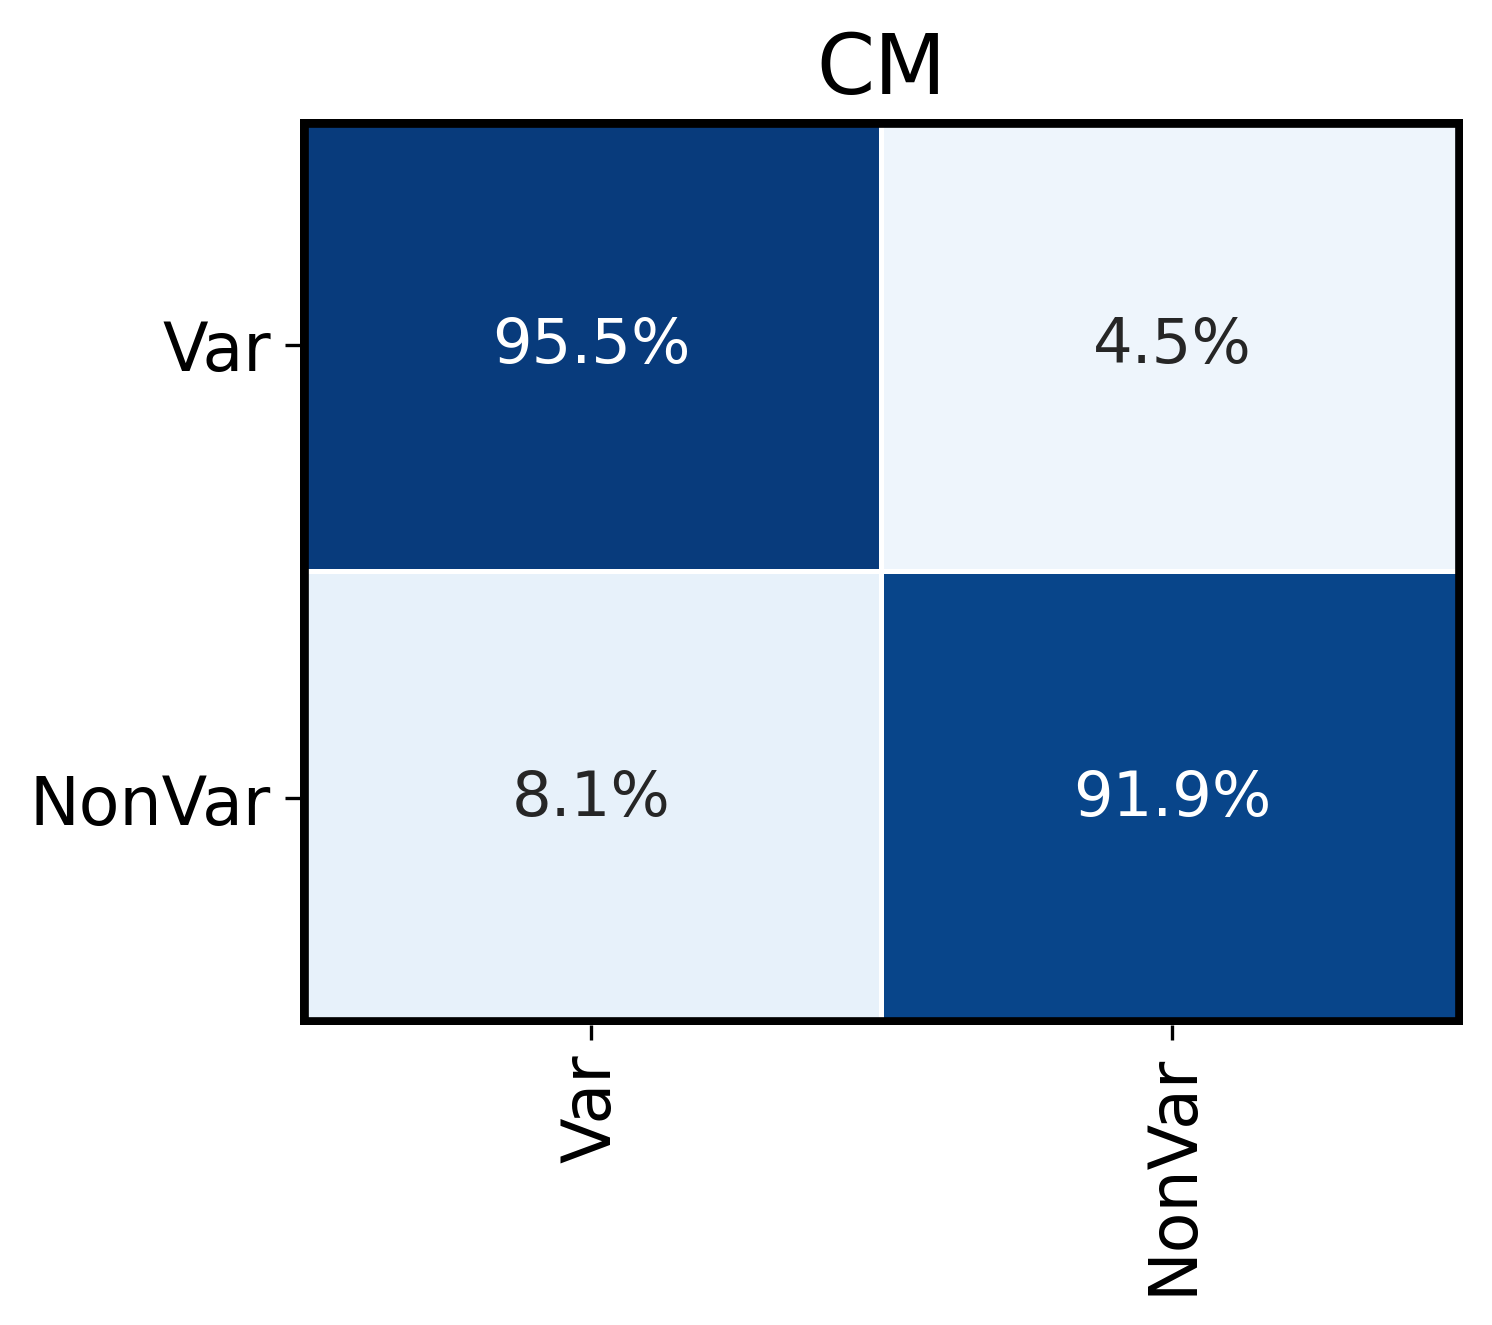

In [249]:
fig, ax = plt.subplots(1,1, figsize=(5,4), dpi=300)
plot_cm(cm, ax)

In [280]:
condition_0 = result['y_true'].numpy() == 0
y_true_ = result['y_true'][condition_0].numpy()
y_pred_ = result['y_pred'][condition_0].numpy()

x_inp_ = result['x_input'][condition_0]
x_time = result['x_time'][condition_0]
x_mask = result['x_mask'][condition_0]

In [281]:
condition = y_true_ != y_pred_

y_true_label = y_true_[condition]
y_pred_label = y_pred_[condition]
x_input = x_inp_[condition]
x_time = x_time[condition]
x_mask = x_mask[condition]

Pred Label: NonVar - True Label: Var
Pred Label: NonVar - True Label: Var


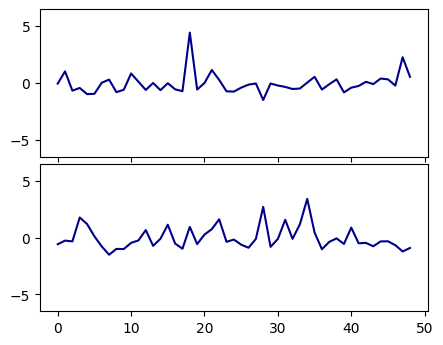

In [282]:
N = 2

fig, axes = plt.subplots(N, 1, figsize=(5,4), sharex=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.3}, dpi=100)

for i in range(N):
    single_x = tf.boolean_mask(x_input[i], x_mask[i])[1:-1]
    single_t = x_time[i]    
    
    single_y = y_true_label[i]
    single_y_pred = y_pred_label[i]
      
    axes[i].plot(single_x, color='darkblue')
    axes[i].set_ylim(-6.5, 6.5)
    print('Pred Label: {} - True Label: {}'.format(class_names[single_y_pred], class_names[single_y]))